In [25]:
#import packages
from nipype.interfaces.io import DataSink, SelectFiles, DataGrabber # Data i/o
from nipype.interfaces.utility import IdentityInterface, Function     # utility
from nipype.pipeline.engine import Node, Workflow, MapNode, JoinNode        # pypeline engine
from pandas import DataFrame, Series,read_csv

#set output file type for FSL to NIFTI_GZ
from nipype.interfaces.fsl.preprocess import FSLCommand
FSLCommand.set_default_output_type('NIFTI_GZ')

# MATLAB setup - Specify path to current SPM and the MATLAB's default mode
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('~/spm12/toolbox')
MatlabCommand.set_default_matlab_cmd("matlab -nodesktop -nosplash")

# Set study variables
#studyhome = '/Users/catcamacho/Box/SNAP/BABIES'
studyhome = '/data/perlman/moochie/user_data/CamachoCat/SNAP'
raw_data = studyhome + '/raw'
preproc_dir = studyhome + '/processed/preproc'
output_dir = studyhome + '/processed/network_analysis'
workflow_dir = studyhome + '/workflows'
subjects_info = read_csv(studyhome + '/misc/rest_subjects_info.csv',index_col=None, dtype={'subject_id':str})
subjects_info = subjects_info[subjects_info['usable']==1]
subjects_info['subject_id'] = subjects_info['subject_id'].apply(lambda x: x.zfill(4))
subjects_list = subjects_info['subject_id'].tolist()

template_atlas = studyhome + '/rois/language_rois_NRN.nii.gz'
template_atlas_key = studyhome + '/rois/language_rois_key_NRN.csv'

proc_cores = 6 # number of cores of processing for the workflows

In [26]:
def correlation_matrix(func,atlas,atlas_labels):
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from os.path import abspath
    from nilearn.input_data import NiftiLabelsMasker
    from nilearn.connectome import ConnectivityMeasure
    from nilearn import plotting
    from pandas import read_csv, DataFrame
    import matplotlib.pyplot as plt

    labels_df = read_csv(atlas_labels, index_col=None)
    labels = labels_df['region_name'].tolist()
    masker = NiftiLabelsMasker(labels_img=atlas, standardize=True)
    time_series = masker.fit_transform(func)
    ts_df = DataFrame(time_series, columns=labels)
    ts_df.to_csv('time_series.csv')

    correlation_measure = ConnectivityMeasure(kind='correlation')
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    corr_mat_df = DataFrame(correlation_matrix,columns=labels,index=labels)
    corr_mat_df.to_csv('correlation_matrix.csv')

    plt.figure()
    plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels,
                         vmax=0.8, vmin=-0.8, reorder=True)
    plt.savefig('corr_matrix.svg')
    plt.close()
    
    sub_atlas_timeseries = abspath('time_series.csv')
    corr_mat_fig = abspath('corr_matrix.svg')
    corr_matrix = abspath('correlation_matrix.csv')
    
    return(corr_matrix, sub_atlas_timeseries, corr_mat_fig)

In [27]:
## File handling Nodes

# Identity node- select subjects
infosource = Node(IdentityInterface(fields=['subject_id']),
                     name='infosource')
infosource.iterables = ('subject_id', subjects_list)

# Datasink- where our select outputs will go
substitutions = [('_subject_id_', '')]
datasink = Node(DataSink(), name='datasink')
datasink.inputs.base_directory = output_dir
datasink.inputs.container = output_dir
datasink.inputs.substitutions = substitutions

# Data grabber
file_template = {'func': preproc_dir + '/fully_processed_func/{subject_id}/final_proc_func.nii.gz'}
selectfiles = Node(SelectFiles(file_template), name='selectfiles')

calc_connectivity = Node(Function(input_names=['func','atlas','atlas_labels'], 
                                  output_names=['corr_matrix','sub_atlas_timeseries','corr_mat_fig'], 
                                  function=correlation_matrix), 
                         name='calc_connectivity')
calc_connectivity.inputs.atlas = template_atlas
calc_connectivity.inputs.atlas_labels = template_atlas_key

In [ ]:
connect_flow = Workflow(name='connect_flow')
connect_flow.connect([(infosource,selectfiles, [('subject_id','subject_id')]),
                      (selectfiles, calc_connectivity, [('func','func')]),
                      
                      (calc_connectivity, datasink, [('corr_matrix','correlation_matrix_4mm'),
                                                     ('corr_mat_fig','corr_matrix_plot_4mm'),
                                                     ('sub_atlas_timeseries','sub_atlas_timeseries_4mm')])
                     ])

connect_flow.base_dir = workflow_dir
#connect_flow.write_graph(graph2use='flat')
connect_flow.run('MultiProc', plugin_args={'n_procs': 10, 'memory_gb':30})

## Modularity Detection and Visualizing Mean Connectivity

<Figure size 432x288 with 0 Axes>

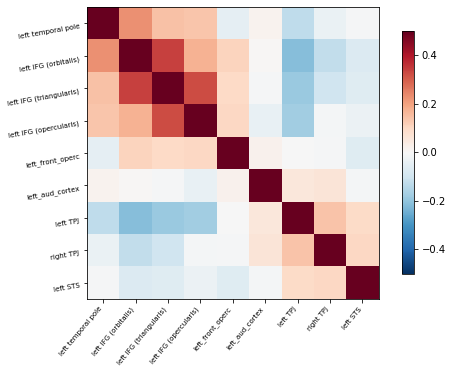

In [30]:
from nilearn import plotting
from pandas import read_csv, DataFrame
import matplotlib.pyplot as plt
import numpy as np

labels_df = read_csv(template_atlas_key, index_col=None)
labels = labels_df['region_name'].tolist()

group_conn_data = read_csv(output_dir + '/correlation_matrix_4mm/{0}/correlation_matrix.csv'.format(subjects_list[0]), index_col=0)
group_conn_mat = group_conn_data.to_numpy()
group_conn_mat = np.expand_dims(group_conn_mat, axis=2)

for sub in subjects_list[1:]:
    temp = read_csv(output_dir + '/correlation_matrix_4mm/{0}/correlation_matrix.csv'.format(sub), index_col=0)
    temp_mat = np.expand_dims(temp.to_numpy(),axis=2)
    group_conn_mat = np.concatenate((group_conn_mat,temp_mat),axis=2)

mean_conn_data = np.average(group_conn_mat,axis=2)
mean_conn = DataFrame(mean_conn_data,columns=labels, index=labels)
mean_conn.to_csv('group_con_4mm.csv')

plt.figure()
plotting.plot_matrix(mean_conn_data, figure=(6, 6), labels=labels,
                     vmax=0.5, vmin=-0.5, reorder=True)

plt.savefig(output_dir+'/group_mean_corr_matrix_4mm_ordered.png')
plt.show()
plt.close()

In [ ]:
from nilearn import plotting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

labels_df = pd.read_csv(template_atlas_key, index_col=None)
labels = labels_df['region_name'].tolist()

plt.figure()
plotting.plot_matrix(conn_diff.to_numpy(), figure=(6, 6), labels=labels,
                     vmax=0.5, vmin=-0.5, reorder=False)
plt.savefig('./group_mean_corr_matrix_diff.png')
plt.show()
plt.close()

Mean modularity score: 0.733


<Figure size 432x288 with 0 Axes>

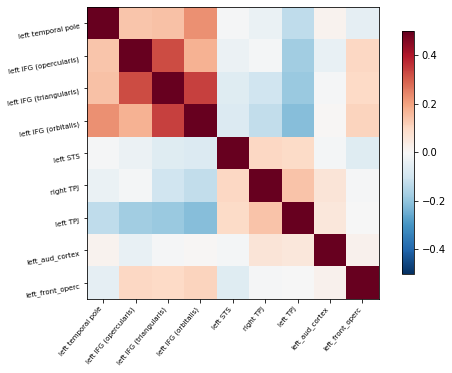

In [31]:
import pandas as pd
import numpy as np

def louvain_comm_detect(adj_matrix,labels,iters):
    import bct
    import pandas as pd
    import numpy as np

    outlist=[]
    q_score = []

    for seed in range(0,iters):
        out = bct.modularity.community_louvain(adj_matrix, gamma=0.25, ci=None, B='negative_sym', seed=seed)
        outlist.append(np.expand_dims(out[0],axis=0))
        q_score.append(out[1])
    
    print('Mean modularity score: {0}'.format(np.round(np.array(q_score).mean(),3)))
    louvs = pd.DataFrame(np.concatenate(outlist,axis=0), columns=labels)
    comm_weights = np.zeros_like(adj_matrix)
    comm_weights = pd.DataFrame(comm_weights, index=labels, columns=labels)

    y=0

    while y < len(labels):
        for x in range(y,len(labels)-1):
            comm_weights.loc[labels[x],labels[y]] = (louvs[labels[x]]==louvs[labels[y]]).astype(float).mean()
            comm_weights.loc[labels[y],labels[x]] = (louvs[labels[x]]==louvs[labels[y]]).astype(float).mean()
        y += 1

    out = bct.modularity.community_louvain(comm_weights.to_numpy(), gamma=0.25, ci=None, B='negative_sym', seed=42)
    final_comms = pd.DataFrame(out[0], index=labels,columns=['NetworkNum'])
    return(comm_weights,final_comms)

def plot_networks(final_comms,adj_matrix_df,out_file):
    import matplotlib.pyplot as plt
    from nilearn import plotting
    
    final_comms['region'] = final_comms.index
    final_comms=final_comms.sort_values(by=['NetworkNum'])
    adj_matrix_df = adj_matrix_df.reindex(final_comms['region'].tolist(),columns=final_comms['region'].tolist())
    
    plt.figure()
    plotting.plot_matrix(adj_matrix_df.to_numpy(), figure=(6, 6), labels=final_comms.region.to_list(),
                     vmax=0.5, vmin=-0.5, reorder=False)

    plt.savefig(out_file)
    plt.show()
    plt.close()

conn = pd.read_csv('group_con_4mm.csv', index_col=0)
labels = conn.columns
adj_matrix = conn.to_numpy()
iters = 100

comm_weights,final_comms = louvain_comm_detect(adj_matrix,labels,iters)
plot_networks(final_comms, conn,'network_conns_4mm.svg')

In [24]:
# compute clustering coefficient for each sub and each kernel
import bct

coeff_data = pd.DataFrame(columns=['N1_corr','N2_corr','N1_cc','N2_cc'])
final_comms['region'] = final_comms.index
final_comms=final_comms.sort_values(by=['NetworkNum'])

subjects_list = subjects_info['subject_id'].tolist()
#subjects_list = subjects_list[0:2]

for sub in subjects_list:
    idx = pd.IndexSlice
    temp = read_csv(output_dir + '/correlation_matrix_4mm/{0}/correlation_matrix.csv'.format(sub), index_col=0)
    temp = temp.reindex(final_comms['region'].tolist(),columns=final_comms['region'].tolist())
    temp.columns = pd.MultiIndex.from_frame(final_comms, names=['network','region'])
    temp.index = pd.MultiIndex.from_frame(final_comms, names=['network','region'])
    for n in [1,2]:
        net = temp.loc[idx[n,n]]
        coeff_data.loc[sub,'N{0}_cc'.format(n)] = bct.clustering_coef_wu(net).mean()
        net[net==1]=np.nan
        coeff_data.loc[sub,'N{0}_corr'.format(n)] = np.nanmean(net.to_numpy())
coeff_data.to_csv('4mm_conn_cc_data.csv')

network1 r=0.75, p=0.0
network2 r=0.06, p=0.643


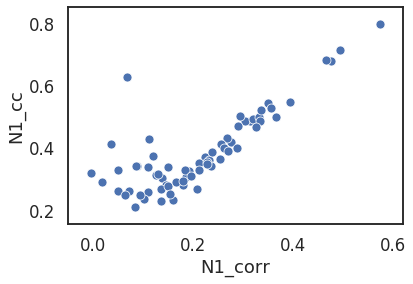

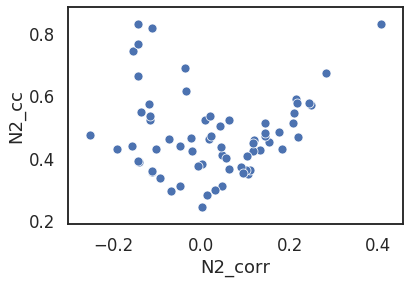

In [38]:
from scipy.stats import spearmanr
import seaborn as sns

r,p = spearmanr(coeff_data['N1_corr'],coeff_data['N1_cc'])
print('network1 r={0}, p={1}'.format(np.round(r,2),np.round(p,3)))
r,p = spearmanr(coeff_data['N2_corr'],coeff_data['N2_cc'])
print('network2 r={0}, p={1}'.format(np.round(r,2),np.round(p,3)))

sns.set(context='talk',style='white')

sns.scatterplot(x='N1_corr',y='N1_cc',data=coeff_data)
plt.savefig('4mm_n1.svg')
plt.show()
plt.close()
sns.scatterplot(x='N2_corr',y='N2_cc',data=coeff_data)
plt.savefig('4mm_n2.svg')
plt.show()
plt.close()

network1 r=0.75, p=0.0
network2 r=0.06, p=0.643


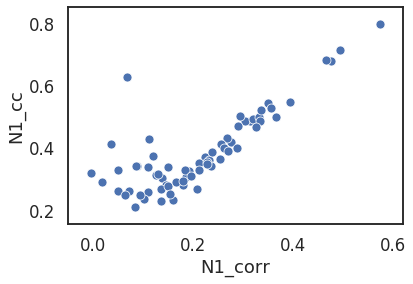

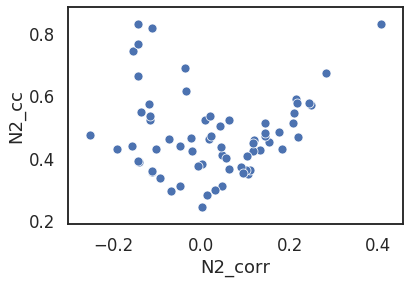

In [39]:
from scipy.stats import spearmanr
import seaborn as sns

coeff_data = pd.read_csv('8mm_conn_cc_data.csv')

r,p = spearmanr(coeff_data['N1_corr'],coeff_data['N1_cc'])
print('network1 r={0}, p={1}'.format(np.round(r,2),np.round(p,3)))
r,p = spearmanr(coeff_data['N2_corr'],coeff_data['N2_cc'])
print('network2 r={0}, p={1}'.format(np.round(r,2),np.round(p,3)))

sns.set(context='talk',style='white')

sns.scatterplot(x='N1_corr',y='N1_cc',data=coeff_data)
plt.savefig('8mm_n1.svg')
plt.show()
plt.close()
sns.scatterplot(x='N2_corr',y='N2_cc',data=coeff_data)
plt.savefig('8mm_n2.svg')
plt.show()
plt.close()